# Voice-Based Cognitive Decline Pattern Detection

## Setup
### Installing and importing req libs

In [1]:
!pip install librosa pydub whisper openai-whisper numpy pandas sklearn matplotlib nltk

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 15.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used

In [1]:
# Import libraries
import os
import librosa
import numpy as np
import pandas as pd
import re
import nltk
from pydub import AudioSegment
import whisper
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
# Download NLTK data
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/varun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Set path to your samples folder
SAMPLE_DIR = "../memotag_task/samples"
audio_files = [os.path.join(SAMPLE_DIR, f) for f in os.listdir(SAMPLE_DIR) if f.endswith(('.flac'))]
print("Audio files:", audio_files)

Audio files: ['../memotag_task/samples/3000-15664-0019.flac', '../memotag_task/samples/84-121123-0002.flac', '../memotag_task/samples/3000-15664-0001.flac', '../memotag_task/samples/8297-275155-0004.flac', '../memotag_task/samples/84-121123-0005.flac']


## Preprocess audio and transcribe
### Converting audio to a more consistent format (WAV) and transcibing using whisper

In [4]:
# Function to convert audio to WAV (if needed)
def convert_to_wav(audio_path, output_path):
    audio = AudioSegment.from_file(audio_path)
    audio.export(output_path, format="wav")
    return output_path

In [5]:
# Preprocess and transcribe
transcriptions = {}
wav_files = []

In [6]:
for audio_path in audio_files:
    # Convert to WAV if not already
    if not audio_path.endswith('.wav'):
        wav_path = audio_path.rsplit('.', 1)[0] + '.wav'
        convert_to_wav(audio_path, wav_path)
    else:
        wav_path = audio_path
    
    wav_files.append(wav_path)
    
    # Transcribe using Whisper
    model = whisper.load_model("base")
    result = model.transcribe(wav_path)
    transcriptions[wav_path] = result["text"]

100%|███████████████████████████████████████| 139M/139M [00:09<00:00, 14.6MiB/s]
/Users/varun/Library/Python/3.9/lib/python/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues rela

In [7]:
# Display transcriptions
for wav_path, transcript in transcriptions.items():
    print(f"File: {wav_path}\nTranscript: {transcript}\n")

File: ../memotag_task/samples/3000-15664-0019.wav
Transcript:  Most of the drainage of the glacier vanishes at once in the porous rocks to appear in springs in the distant valley, and it is only in time of flood that the channel carries much water. Then there are several fine falls in the gorge, 600 feet or more in height.

File: ../memotag_task/samples/84-121123-0002.wav
Transcript:  At this moment, the whole soul of the old man seemed centered in his eyes which became bloodshot. The veins of the throat swelled. His cheeks and temples became purple as though he was struck with epilepsy. Nothing was wanting to complete this but the utterance of a cry.

File: ../memotag_task/samples/3000-15664-0001.wav
Transcript:  Arctic beauty and desolation, with their blessings and dangers, all may be found here to test the endurance and skill of adventurous climbers. But far better than climbing the mountain is going around its warm, fertile base, enjoying its bounties like a bee circling around a 

## Feature Extraction

Extract audio and text features for cognitive decline detection:
- Pauses per sentence
- Hesitation markers (uh, um, etc.)
- Word recall issues (repetitions)
- Speech rate
- Pitch variability
- Sentence completion

In [8]:
# Function to extract features
def extract_features(audio_path, transcript):
    # Load audio
    y, sr = librosa.load(audio_path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    
    # Audio features
    # 1. Pauses (silence segments > 0.5s)
    pauses = librosa.effects.split(y, top_db=20)  # Split on silence
    num_pauses = len(pauses) - 1
    sentences = nltk.sent_tokenize(transcript)
    pauses_per_sentence = num_pauses / max(len(sentences), 1)
    
    # 2. Speech rate (words per second)
    words = transcript.split()
    speech_rate = len(words) / duration if duration > 0 else 0
    
    # 3. Pitch variability
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    valid_pitches = pitches[magnitudes > 0]
    pitch_var = valid_pitches.std() if len(valid_pitches) > 0 else 0
    
    # Text features
    # 4. Hesitation markers
    hesitations = len(re.findall(r"\b(uh|um|er)\b", transcript.lower()))
    
    # 5. Word recall issues (repetitions)
    word_counts = nltk.FreqDist(words)
    repeats = sum(1 for count in word_counts.values() if count > 1)
    
    # 6. Sentence completion (incomplete sentences)
    incomplete = sum(1 for s in sentences if not s.strip().endswith(('.', '!', '?')))
    
    return {
        "pauses_per_sentence": pauses_per_sentence,
        "speech_rate": speech_rate,
        "pitch_variability": pitch_var,
        "hesitations": hesitations,
        "word_repetitions": repeats,
        "incomplete_sentences": incomplete
    }

In [9]:
# Extract features for all samples
features_list = []
for wav_path in wav_files:
    features = extract_features(wav_path, transcriptions[wav_path])
    features["file"] = os.path.basename(wav_path)
    features_list.append(features)

# Create DataFrame
features_df = pd.DataFrame(features_list)
print("Features DataFrame:")
print(features_df)

# Save to CSV for reproducibility
features_df.to_csv("features.csv", index=False)

Features DataFrame:
   pauses_per_sentence  speech_rate  pitch_variability  hesitations  \
0                10.50     2.894438        1134.620972            0   
1                 1.25     3.579255        1112.885376            0   
2                10.50     2.348993        1103.765381            0   
3                 7.00     2.060086        1133.309814            0   
4                15.00     3.007519        1168.863892            0   

   word_repetitions  incomplete_sentences                  file  
0                 3                     0   3000-15664-0019.wav  
1                 5                     0    84-121123-0002.wav  
2                 6                     0   3000-15664-0001.wav  
3                 1                     0  8297-275155-0004.wav  
4                 3                     0    84-121123-0005.wav  


## Analysis

Using PCA to visualize samples and identify outliers as potential indicators of cognitive decline.

In [10]:
# Prepare feature matrix (exclude 'file' column)
feature_columns = [col for col in features_df.columns if col != 'file']
X = features_df[feature_columns].values

In [11]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

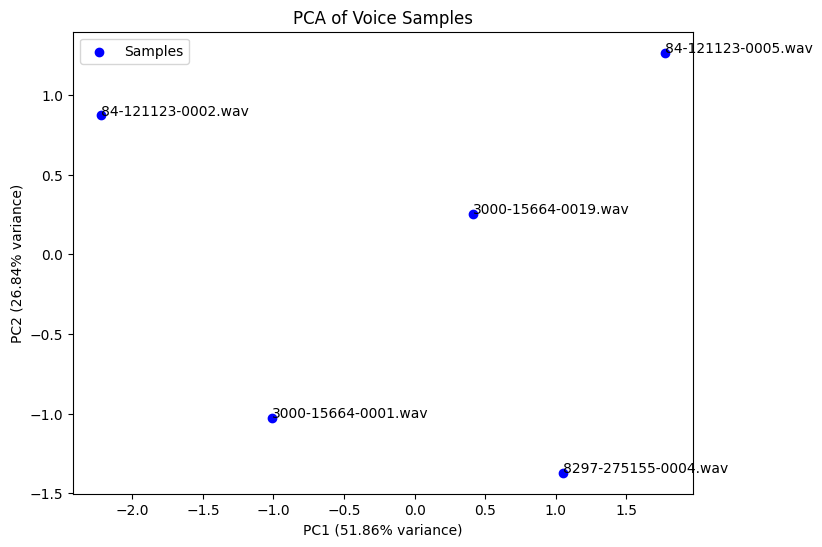

In [13]:
# Visualize PCA results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', label='Samples')
for i, txt in enumerate(features_df['file']):
    plt.annotate(txt, (X_pca[i, 0], X_pca[i, 1]))
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA of Voice Samples')
plt.legend()
plt.savefig('pca_plot.png')
plt.show()

In [14]:
# Analyze feature contributions
loadings = pd.DataFrame(pca.components_.T, index=feature_columns, columns=['PC1', 'PC2'])
print("PCA Loadings (feature contributions):")
print(loadings)

PCA Loadings (feature contributions):
                           PC1       PC2
pauses_per_sentence   0.523705  0.097985
speech_rate          -0.299208  0.858840
pitch_variability     0.595907  0.479546
hesitations           0.000000 -0.000000
word_repetitions     -0.530191  0.151093
incomplete_sentences  0.000000 -0.000000


In [15]:
# Identify outliers (samples far from mean in PCA space)
mean_pca = X_pca.mean(axis=0)
distances = np.sqrt(((X_pca - mean_pca) ** 2).sum(axis=1))
outlier_threshold = distances.mean() + 2 * distances.std()
outliers = features_df[distances > outlier_threshold]['file'].tolist()
print("Potential at-risk samples (outliers):", outliers)

Potential at-risk samples (outliers): []


## Visualizations

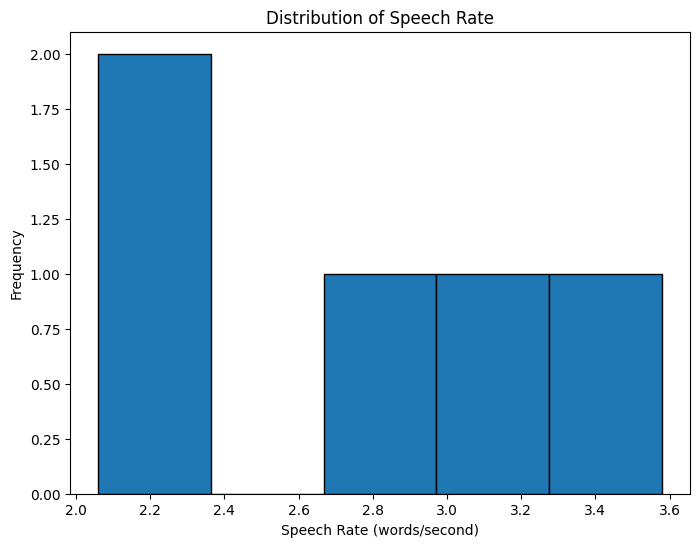

In [16]:
# Histogram of speech rate
plt.figure(figsize=(8, 6))
plt.hist(features_df['speech_rate'], bins=5, edgecolor='black')
plt.xlabel('Speech Rate (words/second)')
plt.ylabel('Frequency')
plt.title('Distribution of Speech Rate')
plt.savefig('speech_rate_histogram.png')
plt.show()

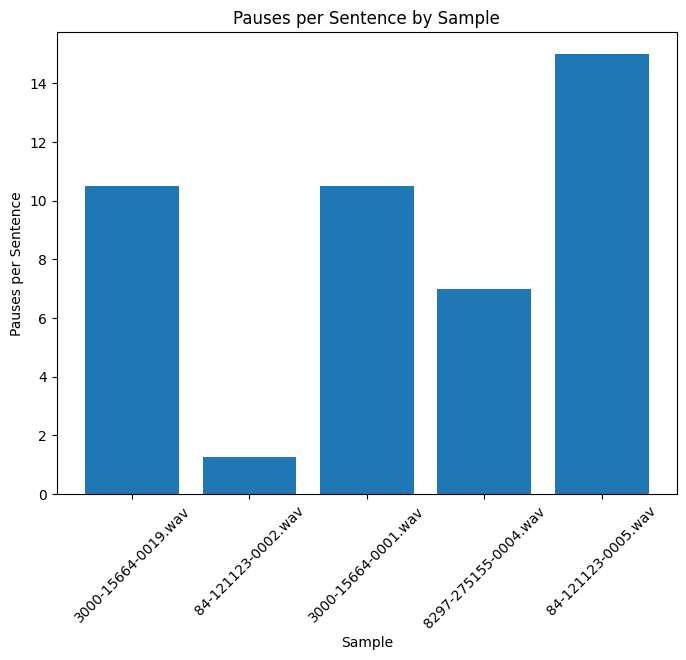

In [17]:
# Bar plot of pauses per sentence
plt.figure(figsize=(8, 6))
plt.bar(features_df['file'], features_df['pauses_per_sentence'])
plt.xlabel('Sample')
plt.ylabel('Pauses per Sentence')
plt.title('Pauses per Sentence by Sample')
plt.xticks(rotation=45)
plt.savefig('pauses_bar.png')
plt.show()

## Optional: API-Ready Function
Function to compute a risk score based on extracted features for a given audio file.

In [18]:
def compute_risk_score(audio_path, scaler, pca, threshold):
    """
    Compute a risk score for cognitive decline based on audio features.
    
    Args:
        audio_path (str): Path to the audio file.
        scaler (StandardScaler): Trained scaler from the analysis.
        pca (PCA): Trained PCA model from the analysis.
        threshold (float): Outlier threshold from PCA distances.
    
    Returns:
        dict: File name and risk score (0-1).
    """
    # Transcribe
    model = whisper.load_model("base")
    transcript = model.transcribe(audio_path)["text"]
    
    # Extract features (using the same function from Step 3)
    features = extract_features(audio_path, transcript)
    feature_values = [features[col] for col in feature_columns]
    
    # Standardize and apply PCA
    X_new = scaler.transform([feature_values])
    X_new_pca = pca.transform(X_new)
    
    # Compute distance from mean PCA point
    mean_pca = X_pca.mean(axis=0)
    distance = np.sqrt(((X_new_pca - mean_pca) ** 2).sum())
    
    # Risk score (0-1, based on distance relative to threshold)
    risk_score = min(distance / threshold, 1.0)
    return {"file": os.path.basename(audio_path), "risk_score": risk_score}

In [19]:
# Test the function
print("Risk Scores for Samples:")
for wav_path in wav_files:
    score = compute_risk_score(wav_path, scaler, pca, outlier_threshold)
    print(f"Risk score for {score['file']}: {score['risk_score']:.2f}")

Risk Scores for Samples:


/Users/varun/Library/Python/3.9/lib/python/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=devi

Risk score for 3000-15664-0019.wav: 0.16


/Users/varun/Library/Python/3.9/lib/python/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=devi

Risk score for 84-121123-0002.wav: 0.80


/Users/varun/Library/Python/3.9/lib/python/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=devi

Risk score for 3000-15664-0001.wav: 0.48


/Users/varun/Library/Python/3.9/lib/python/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=devi

Risk score for 8297-275155-0004.wav: 0.58


/Users/varun/Library/Python/3.9/lib/python/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=devi

Risk score for 84-121123-0005.wav: 0.73
